## Importing Necessary Libraries

We begin by importing the essential libraries required for data processing, visualization, and machine learning:

- `h5py`: Handles HDF5 files for structured data storage and retrieval.
- `pandas`: Provides data manipulation and analysis tools.
- `awkward`: Efficiently manages hierarchical and nested data structures.
- `km3io`: A library for reading and processing KM3NeT data.
- `matplotlib.pyplot`: A standard Python library for data visualization.
- `numpy`: Fundamental package for numerical computations.
- `seaborn`: Enhances visualization aesthetics and statistical plotting.

### Machine Learning Libraries:
- `sklearn.neighbors.KNeighborsRegressor`: Implements k-Nearest Neighbors regression.
- `sklearn.model_selection.train_test_split`: Splits data into training and testing sets.
- `sklearn.metrics`: Provides performance evaluation metrics (MAE, MSE, R²).
- `sklearn.preprocessing.StandardScaler`: Standardizes features by removing the mean and scaling to unit variance.

### Ensemble Learning Models:
- `sklearn.ensemble.GradientBoostingRegressor`: A boosting algorithm for regression tasks.
- `sklearn.ensemble.RandomForestRegressor`: An ensemble learning method using decision trees.
- `sklearn.ensemble.ExtraTreesRegressor`: Similar to random forests but with more randomness in feature selection.
- `sklearn.ensemble.HistGradientBoostingRegressor`: A histogram-based gradient boosting implementation.

### Neural Network Model:
- `sklearn.neural_network.MLPRegressor`: Implements a multi-layer perceptron (MLP) for regression tasks.

In [1]:
import h5py
import pandas as pd
import awkward as ak
import km3io as ki
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import (
    GradientBoostingRegressor,
    RandomForestRegressor,
    ExtraTreesRegressor,
    HistGradientBoostingRegressor,
)
from sklearn.neural_network import MLPRegressor

## Loading HDF5 Data

In this section, we load the dataset stored in an HDF5 file using the `h5py` library. 

- **Filename**: The dataset is located at `'/Desktop/Energy_Reconstruction/Data_for_ML.h5'`.
- **Data Handling**: The `h5py.File()` function is used to open the file, allowing access to its structured data.

This dataset contains various features that will be used for training machine learning models.

In [2]:
filename = '/Desktop/Energy_Reconstruction/Data_for_ML.h5'

Data = h5py.File(filename)

## Extracting Features and Labels

We extract relevant features from the HDF5 dataset and store them as NumPy arrays. These features will be used as inputs for training machine learning models.

### **Target Variable (Label)**:
- `y`: The energy (`E`) values, which we aim to predict.

### **Extracted Features**:
- `a`: A parameter related to the dataset.
- `channel_id`: Identifies the detection channel.
- `dir_x`, `dir_y`, `dir_z`: Directional components of the detected signal.
- `dom_id`: Identifies the optical module detecting the event.
- `pos_x`, `pos_y`, `pos_z`: Spatial coordinates of the detection.
- `t`: Timestamp of the event.
- `tdc`: Time-to-digital converter values for time measurements.
- `tot`: Time-over-threshold values related to signal strength.
- `trig`: Trigger information indicating if the event was registered.

These features collectively provide spatial, temporal, and identification information crucial for energy reconstruction.

In [3]:
y = Data['E'][:]

a = Data['a'][:]

channel_id = Data['channel_id'][:]

dir_x = Data['dir_x'][:]

dir_y = Data['dir_y'][:]

dir_z = Data['dir_z'][:]

dom_id = Data['dom_id'][:]

pos_x = Data['pos_x'][:]

pos_y = Data['pos_y'][:]

pos_z = Data['pos_z'][:]

t = Data['t'][:]

tdc = Data['tdc'][:]

tot = Data['tot'][:]

trig = Data['trig'][:]


## Constructing the Feature Matrix `X`

To prepare the data for machine learning models, we construct a feature matrix `X` by combining all relevant features into a single NumPy array.

### **Feature Engineering:**
We use `np.column_stack()` to horizontally stack multiple feature arrays into a structured dataset where:
- Each **row** represents a single event (data sample).
- Each **column** represents a specific feature.

This feature matrix `X` will serve as input for the regression models in the subsequent steps.

In [4]:
X = np.column_stack([a,
channel_id,
dir_x,
dir_y,
dir_z,
dom_id,
pos_x,
pos_y,
pos_z,
t,
tdc,
tot, 
trig])


In [5]:
print(X.shape)

(6676, 13)


## Applying Logarithmic Transformation to `y`

To improve the performance of regression models, we apply a **logarithmic transformation** to the target variable `y` (energy `E`):

$$ y = \log_{10}(y) $$

### **Why Use Log Transformation?**
1. **Handles Skewness**: Energy values are several order of magnitude. Taking the logarithm helps normalize the distribution (Gaussian).
2. **Improves Model Performance**: Many regression models perform better with normally distributed data.
3. **Reduces Variance**: This transformation reduces the impact of outliers and stabilizes variance.

After this step, `y` will represent the base-10 logarithm of energy values instead of their raw form.

In [6]:
y = np.log10(y)

## Standardizing the Feature Matrix `X`

To ensure all features have a similar scale, we apply **feature standardization** using `StandardScaler` from `sklearn.preprocessing`:

### **Why Standardize?**
1. **Ensures Uniform Scale**: Features may have different units and magnitudes (e.g., spatial coordinates vs. time values). Standardization ensures all features contribute equally.
2. **Improves Model Convergence**: Many machine learning algorithms (e.g., gradient-based models) perform better when features are standardized.
3. **Reduces Sensitivity to Outliers**: While it does not eliminate outliers, standardization reduces their influence.

### **How Standardization Works?**
The `StandardScaler` transforms the data by subtracting the mean and dividing by the standard deviation:

$$
X_{\text{scaled}} = \frac{X - \mu}{\sigma}
$$

where:
- $\mu$ is the mean of each feature.
- $\sigma$ is the standard deviation of each feature.

### **Implementation:**
1. **Initialize** the `StandardScaler`.
2. **Fit and transform** `X` to apply standardization.

After this step, `X_scaled` contains standardized features, making them suitable for machine learning models.

In [7]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Inverting the Log Transformation of `y_test`

Since we previously applied a **logarithmic transformation** to `y` using:

$$
y = \log_{10}(y)
$$

we now **reverse** this transformation to obtain the original energy values:

$$
y_{\text{test original}} = 10^{y_{\text{test}}}
$$

### **Why Revert the Transformation?**
1. **Interpretability**: The model predicts `log10(E)`, but we need actual energy values for evaluation.
2. **Comparison with True Values**: To assess model performance, predictions must be in the same scale as the original dataset.
3. **Post-processing**: The results are used in scientific applications, they must be in their original physical units.

This step ensures that the predictions are meaningful and comparable to the original energy values.

In [19]:
y_test_original = 10 ** y_test

["HistGradientBoosting", HistGradientBoostingRegressor(learning_rate=0.1, max_iter=500)],
    ["LightGBM", lgb.LGBMRegressor(random_state=0, n_jobs=-1, learning_rate=0.1, num_iterations=100)],
    ["XGBoost", xgb.XGBRegressor(n_jobs=-1, random_state=0, learning_rate=0.1)],
    ["MLP", MLPRegressor(random_state=0, hidden_layer_sizes=(100, 50, 25), max_iter=100)]
    ["GradientBoosting", GradientBoostingRegressor(random_state=0, learning_rate=0.5, n_estimators=100)],
    ["ExtraTrees", ExtraTreesRegressor(random_state=0, n_jobs=-1, n_estimators=25)],

## Training an Extra Trees Regressor Model

We train an **Extra Trees Regressor**, an ensemble learning model based on decision trees.

### **Why Use Extra Trees Regressor?**
1. **Handles Non-Linearity**: Decision tree-based models can capture complex relationships in data.
2. **Robust to Noise**: The random feature selection reduces overfitting.
3. **Parallel Processing**: The model supports parallel computation (`n_jobs=-1`), speeding up training.
4. **Feature Importance**: Extra Trees can provide insights into feature relevance.

### **Model Parameters:**
- `random_state=0`: Reproducibility of results.
- `n_jobs=-1`: Utilizes all available CPU cores for parallel processing.
- `n_estimators=25`: Specifies the number of decision trees in the ensemble.

### **Training the Model:**
The `.fit(X_train, y_train)` method trains the model using the standardized training data.

After this step, the trained model can be used for making predictions and evaluating performance.

In [29]:
model = ExtraTreesRegressor(random_state=0, n_jobs=-1, n_estimators=25).fit(X_train, y_train)

In [30]:
y_pred_log = model.predict(X_test)

## Evaluating Model Performance

After training the model, we evaluate its performance using common regression metrics.

### **Step 2: Computing Performance Metrics**
We use three key evaluation metrics to assess the model's accuracy:

1. **Mean Absolute Error (MAE)**:
   $$
   MAE = \frac{1}{n} \sum |y_{\text{true}} - y_{\text{pred}}|
   $$
   - Measures the average absolute difference between actual and predicted values.
   - Lower values indicate better performance.

2. **Mean Squared Error (MSE)**:
  $$
   MSE = \frac{1}{n} \sum (y_{\text{true}} - y_{\text{pred}})^2
   $$
   - Penalizes larger errors more than MAE.
   - Useful for detecting outlier impact.

3. **R² Score (Coefficient of Determination)**:
   $$
   R^2 = 1 - \frac{\sum (y_{\text{true}} - y_{\text{pred}})^2}{\sum (y_{\text{true}} - \bar{y})^2}
   $$
   - Measures how well the model explains the variance in the data.
   - A score close to 1 indicates a strong predictive model.

These metrics help assess the accuracy, precision, and reliability of the model in predicting energy values.

In [31]:
y_pred = 10 ** y_pred_log

# Calculate performance metrics
mae = mean_absolute_error(y_test_original, y_pred)
mse = mean_squared_error(y_test_original, y_pred)
r2 = r2_score(y_test_original, y_pred)

In [32]:
print(f"Model Performance:")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R2 Score: {r2}")

Model Performance:
MAE: 3803604.09532761
MSE: 168347163283487.22
R2 Score: 0.08796914907902909


## Defining Log-Spaced Bins

We create an array of bins using `np.logspace()` for data visualization or histogram-based evaluation.

### **Understanding Log-Spaced Bins**
The function `np.logspace(start, stop, num_bins)` generates `num_bins` values spaced **logarithmically** between `10^start` and `10^stop`. 

### **Parameters Used:**
- `start = 1`: The smallest bin starts at $$( 10^1 = 10 )$$.
- `stop = 9`: The largest bin ends at $$( 10^9 )$$.
- `num_bins = 50`: Defines the number of bins between these two values.

### **Why Use Log-Spaced Bins?**
1. **Better Representation of Energy Scale**: Energy values span several orders of magnitude, and log bins prevent bias toward lower values.
2. **Improved Histogram Visualization**: Logarithmic binning is useful when dealing with data distributed across multiple scales.
3. **Ensures Even Distribution**: Log bins ensure data points are distributed appropriately across a wide range of values.

This array can be used for visualizing distributions or analyzing model predictions within different energy ranges.

In [33]:
BINS = np.logspace(1,9,50)

## Log-Log Histogram of Predicted vs. Actual Energy

This plot compares the **actual energy values** (`y_test_original`) with the **predicted energy values** (`y_pred`) using a histogram with logarithmic binning.

### **Plot Features:**
- **Histogram Representation**: Both distributions are plotted as step histograms to maintain clarity and avoid overlapping.
- **Logarithmic Scales**:
  - The **x-axis** (`Energy in GeV`) is set to a log scale to accommodate the wide range of energy values.
  - The **y-axis** (`Frequency`) is also in log scale to better visualize differences in distribution.

### **Purpose of the Plot:**
- Helps **visualize how well the model's predictions align** with the actual energy values.
- Reveals **biases or discrepancies** between predicted and true energy distributions.
- A useful diagnostic tool to assess model performance across different energy scales.

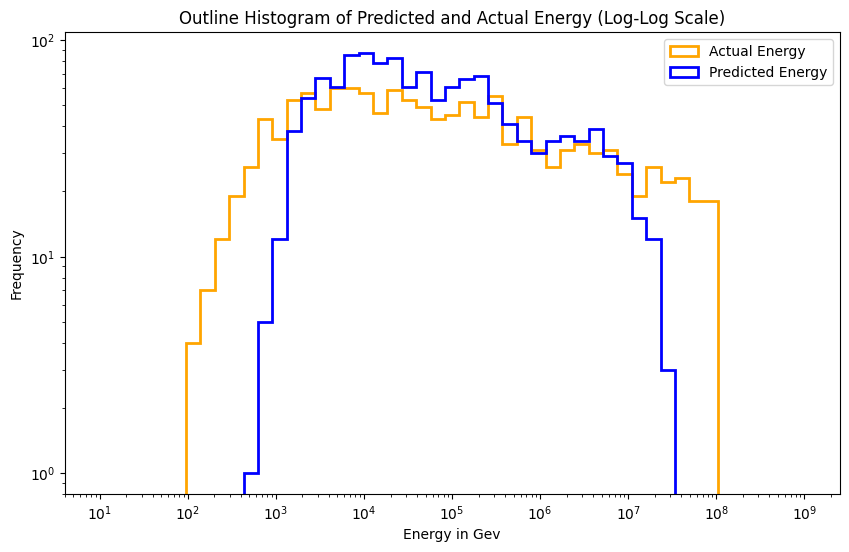

In [34]:
plt.figure(figsize=(10, 6))

plt.hist(y_test_original, bins=BINS, histtype='step', color='orange', linewidth=2, label='Actual Energy')
plt.hist(y_pred, bins=BINS, histtype='step', color='blue', linewidth=2, label='Predicted Energy')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Energy in Gev')
plt.ylabel('Frequency')
plt.title('Outline Histogram of Predicted and Actual Energy (Log-Log Scale)')

plt.legend()

plt.show()

## Residual Calculation

The **residuals** represent the difference between actual and predicted energy values:

$$
\text{residuals} = y_{\text{test original}} - y_{\text{pred}}
$$

### **Why Analyze Residuals?**
- Residuals help **evaluate model accuracy** by showing deviations from true values.
- A well-performing model should have **residuals centered around zero**, with no strong patterns.
- Large residuals indicate **poor predictions** or potential biases in the model.

This residual data can be further analyzed through visualizations such as histograms or scatter plots to assess prediction quality.

In [35]:
import seaborn as sns
residuals = y_test_original - y_pred

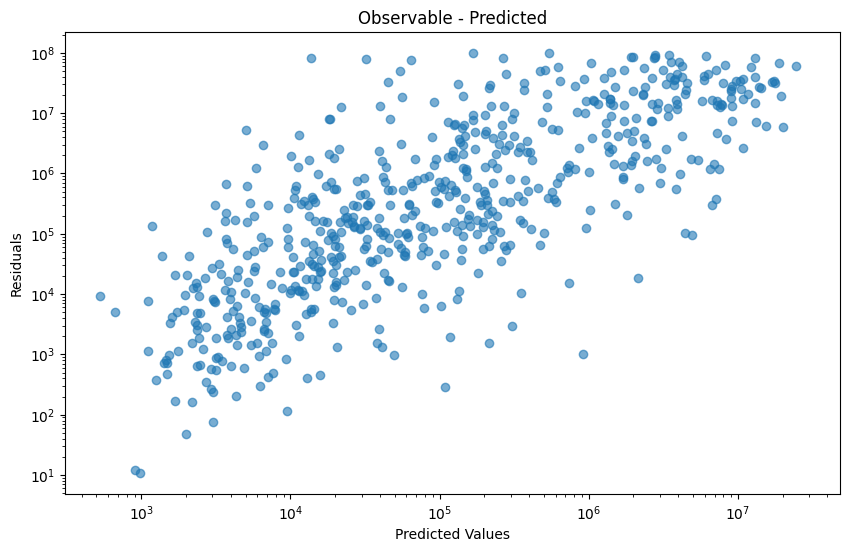

In [36]:
plt.figure(figsize=(10, 6))
#sns.residplot(x=y_pred, y=residuals,scatter_kws={'alpha': 0.5})
plt.scatter(y_pred, residuals, alpha=0.6)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Observable - Predicted')
plt.axhline(y=0, color='r', linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.show()

## 2D Correlation Plot: True vs. Predicted Energy

This plot visualizes the correlation between **true energy values** and **predicted energy values** using a **2D density color map**.

### **Purpose of the Plot:**
- Evaluates how well the predicted energy values align with the true energy values.
- Helps identify systematic biases and deviations.
- The spread of points around the diagonal indicates prediction accuracy and uncertainty.

### **Key Metrics Displayed:**
- **Pearson Correlation Coefficient (`c`)**: Measures linear correlation between true and predicted values.
- **R² Score**: Assesses how well the predictions explain variance in true values.
- These metrics are shown in the legend to summarize model performance.

This visualization is very important give the **overall accuracy and reliability** of the energy reconstruction model.

MAE = 3628433.514, MSE = 153862414162279.438, R2 = 0.166


/Users/meskara/Library/Python/3.9/lib/python/site-packages/numpy/ma/extras.py:700: RuntimeWarning: invalid value encountered in scalar divide
  avg = np.multiply(a, wgt,


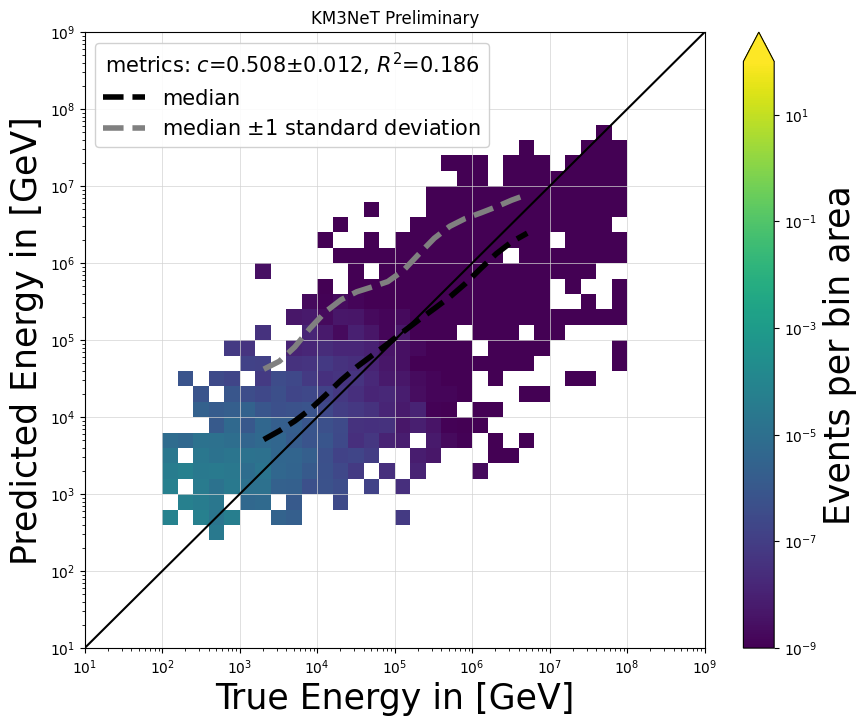

In [37]:
import h5py
import pandas as pd
import awkward as ak
import km3io as ki
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn

from matplotlib.colors import LogNorm
from scipy.ndimage import gaussian_filter

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

# --------------------------------------------------------------------------
# 1) LOAD & PREPARE DATA (Your First Code)
# --------------------------------------------------------------------------
filename = '/Users/meskara/Desktop/Energy_Reconstruction/Data_for_ML.h5'
Data = h5py.File(filename)

y = Data['E'][:]            # Target (energy)
a = Data['a'][:]
dir_x = Data['dir_x'][:]
dir_y = Data['dir_y'][:]
dir_z = Data['dir_z'][:]
pos_x = Data['pos_x'][:]
pos_y = Data['pos_y'][:]
pos_z = Data['pos_z'][:]
t = Data['t'][:]
tdc = Data['tdc'][:]
tot = Data['tot'][:]
trig = Data['trig'][:]

X = np.column_stack([
    a,
    dir_x,
    dir_y,
    dir_z,
    pos_x,
    pos_y,
    pos_z,
    t,
    tdc,
    tot,
    trig
])

y_log= np.log10(y)  

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  

X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, 
    y_log, 
    test_size=0.2, 
    random_state=42
)
model = HistGradientBoostingRegressor(

).fit(X_train, y_train_log)

y_pred_log = model.predict(X_test)
y_pred = 10 ** y_pred_log       # predicted energy
y_test_original = 10 ** y_test_log  # true energy

mae = mean_absolute_error(y_test_original, y_pred)
mse = mean_squared_error(y_test_original, y_pred)
r2_val = r2_score(y_test_original, y_pred)

print(f"MAE = {mae:.3f}, MSE = {mse:.3f}, R2 = {r2_val:.3f}")

# If you want your original 1D log-log hist plot:
# --------------------------------------------------------------------------
# BINS_1D = np.logspace(1, 9, 50)
# plt.figure(figsize=(10, 6))
# plt.hist(y_test_original, bins=BINS_1D, histtype='step', color='orange', linewidth=2, label='Actual')
# plt.hist(y_pred,         bins=BINS_1D, histtype='step', color='blue',   linewidth=2, label='Predicted')
# plt.xscale('log')
# plt.yscale('log')
# plt.xlabel('Energy [GeV]')
# plt.ylabel('Frequency')
# plt.title('1D Histogram: Predicted vs. Actual Energy (Log-Log Scale)')
# plt.legend()
# plt.show()

# --------------------------------------------------------------------------
# 2) 2D Correlation
# --------------------------------------------------------------------------

# Calculating the correlation coefficient
def m(x, w):
    """Weighted Mean"""
    return np.sum(x * w) / np.sum(w)

def cov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - m(x, w)) * (y - m(y, w))) / np.sum(w)

def corr(x, y, w):
    """Weighted Correlation"""
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))

def corr_err(x, y, w):
    """Weighted Correlation"""
    return np.sqrt((1.-(corr(x,y,w))**2) / (len(x)-2.))

def weighted_avg_and_std(values, weights) -> (float,float):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.ma.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.ma.average((values-average)**2, weights=weights)
    return (average, np.sqrt(variance))

def weighted_quantiles(values, weights, quantiles=0.5, interpolate=False):

    if len(values):
        i = values.argsort()
        sorted_weights = weights[i]
        sorted_values = values[i]
        Sn = sorted_weights.cumsum()

        if interpolate:
            Pn = (Sn - sorted_weights/2 ) / Sn[-1]
            return np.interp(quantiles, Pn, sorted_values)
        else:
            return sorted_values[np.searchsorted(Sn, quantiles * Sn[-1])]
    else:
        return np.nan

w = np.ones_like(y_test_original)

BINS = np.append([0],np.logspace(-3,11,14*5+1))

H, x_bin_edges, y_bin_edges = np.histogram2d(
    y_test_original,y_pred,
    bins=[BINS,BINS],
    weights=w
#     weights=w_test_scaled
)

counts, x_bin_edges, y_bin_edges = np.histogram2d(y_test_original,y_pred,bins=[BINS,BINS],)

x_bin_centers = 0.5*(x_bin_edges[:-1]+x_bin_edges[1:])
y_bin_centers = 0.5*(y_bin_edges[:-1]+y_bin_edges[1:])

x_temp = np.asarray(y_test_original)
y_temp = np.asarray(y_pred)

xses = np.floor(x_bin_centers).astype(int)

avgs = np.array([weighted_quantiles(y_temp[(x_temp>=x_bin_edges[i])&(x_temp<x_bin_edges[i+1])],weights=w[(x_temp>=x_bin_edges[i])&(x_temp<x_bin_edges[i+1])], interpolate=False) for i in range(len(x_bin_centers))])
stds = np.array([weighted_avg_and_std(values=y_temp[(x_temp>=x_bin_edges[i])&(x_temp<x_bin_edges[i+1])], weights=w[(x_temp>=x_bin_edges[i])&(x_temp<x_bin_edges[i+1])])[1] for i in range(len(x_bin_centers))]) # this computes weighted std
cts = np.array([np.sum((x_temp>=x_bin_edges[i])&(x_temp<x_bin_edges[i+1])) for i in range(len(x_bin_centers))])

sig = 1.5

avg_m_std=avgs-stds
low_slc=avg_m_std>-np.inf

x_up=xses
y_up=gaussian_filter(avgs+stds,sigma=sig)
x_mid=x_up
y_mid=gaussian_filter(avgs,sigma=sig)
x_down=xses[low_slc]
y_down=gaussian_filter(avg_m_std,sigma=sig)[low_slc]

# to norm by bin area:
dx = np.diff(BINS)
area = dx[:,  None] * dx

plt.figure(figsize=(10, 8))

pcm = plt.pcolormesh(
        x_bin_edges, 
        y_bin_edges, 
        (H / area).T, 
        cmap='viridis',
        norm=LogNorm(vmin=1e-9, vmax=1e2),
        shading='auto'
    )

plt.xlabel("True Energy in [GeV]", fontsize=25)
plt.ylabel("Predicted Energy in [GeV]", fontsize=25) #  (JMuon)
plt.grid(color='lightgray', linestyle='-', linewidth=0.5,animated=True,zorder=-1)
plt.plot(plt.xlim(), plt.ylim(),color='k',linestyle='-') # plot the diagonal

plt.plot(x_mid,y_mid, color='k',linestyle='dashed',linewidth=4,label='median')
plt.plot(x_down, y_down, color='gray',linestyle='dashed',linewidth=4)
plt.plot(x_up, y_up, color='gray', label='median $\pm$1 standard deviation',linestyle='dashed',linewidth=4)

plt.loglog(base = 10)

# we compute the flattened arrays of values for 2D bins to compute bin-wise correlation and R2-score:
trues = []
preds = []
bin_weights = []

for xbe in range(len(x_bin_edges)-1):
    for ybe in range(len(y_bin_edges)-1):
        current_bin = (x_temp>=x_bin_edges[xbe]) & (x_temp<x_bin_edges[xbe+1]) & (y_temp>=y_bin_edges[ybe]) & (y_temp<y_bin_edges[ybe+1])
        bin_weights.append(np.sum(w[current_bin]))
        trues.append(x_bin_edges[1:][xbe])
        preds.append(y_bin_edges[1:][ybe])

trues=np.array(trues)
preds=np.array(preds)
bin_weights=np.array(bin_weights)

plt.xlim(1e1,1e9)
plt.ylim(1e1,1e9)

c=corr(trues,preds, bin_weights)
c_err=corr_err(trues,preds, bin_weights)
r2=r2_score(trues,preds,sample_weight=bin_weights)
s=f'metrics: $c$={c:.3f}$\pm${c_err:.3f}, $R^2$={r2:.3f}'

plt.title('KM3NeT Preliminary')
title_txt=s
plt.legend(title=title_txt,title_fontsize=15,fontsize=15, markerscale=1,loc='upper left',framealpha=0.9) # , loc='upper right'  , bbox_to_anchor=(0.7,1),framealpha=0.9
# plt.title("detector: "+DET+" | "+sel_txt+"metrics: $c$=%3.2f$\pm$%3.2f, $R^2$=%3.2f" % (corr(trues,preds, bin_weights),corr_err(trues,preds, bin_weights),r2_score(trues,preds,sample_weight=bin_weights)),size = 20)


plt.colorbar(pcm, extend='max').set_label(label='Events per bin area', size=25)